# 0. 데이터 업로드 및 네트워크 데이터 설정

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from google.colab import drive
from sklearn.linear_model import LinearRegression

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 파일 호출
data_path: str = "/content/drive/MyDrive/AI Tech/프로젝트/Level 1. 비트코인 상승하락 시계열 분류 예측/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [4]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:09<00:00, 11.69it/s]


In [5]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_block-interval_block_interval':'block_interval',
    'hourly_network-data_block-count_block_count':'block_count',
    'hourly_network-data_block-bytes_block_bytes':'block_bytes',
    'hourly_network-data_blockreward_blockreward':'blockreward',
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_tokens-transferred_tokens_transferred_total': 'token_transferred',
    'hourly_network-data_tokens-transferred_tokens_transferred_mean':
    'token_transferred_mean',
    'hourly_network-data_tokens-transferred_tokens_transferred_median':
    'token_transferred_median',
    'hourly_network-data_hashrate_hashrate':
    'hashrate',
    'hourly_network-data_difficulty_difficulty':
    'difficulty',
    'hourly_network-data_fees-transaction_fees_transaction_mean':
    'fees_transaction',
    'hourly_network-data_fees_fees_total':
    'fees',
    'hourly_network-data_velocity_velocity_supply_total':
    'velocity_supply',
    'hourly_network-data_utxo-count_utxo_count':
    'utxo_count',
    'hourly_network-data_supply_supply_total':
    'supply_total',
    'hourly_network-data_supply_supply_new':
    'supply_new',
    'hourly_network-data_fees_fees_block_mean':
    'fees_block_mean',
    'hourly_network-data_fees-transaction_fees_transaction_median':
    'fees_transaction_median',
}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 24)

##0-1. 결측치 확인

In [6]:
eda_df = df.loc[df["_type"] == "train"]
missing_values = eda_df.isnull().sum()
missing_percentage = (missing_values / len(eda_df)) * 100
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

,0
token_transferred_mean,0.216895
fees_block_mean,0.216895
block_interval,0.216895
block_bytes,0.216895
fees_transaction,0.216895
difficulty,0.216895
token_transferred_median,0.000000
supply_new,0.000000
supply_total,0.000000
utxo_count,0.000000


## 0-2. 타겟값 분포 확인

In [8]:
eda_df["target"].value_counts()/len(eda_df)

,count
target,
2.0,0.419064
1.0,0.404566
3.0,0.091895
0.0,0.084475


In [9]:
eda_df["target"].value_counts()

,count
target,
2.0,3671
1.0,3544
3.0,805
0.0,740


In [10]:
pd.set_option('display.max_rows', None)  # 생략 없이 모든 행 출력
pd.set_option('display.max_columns', None)  # 생략 없이 모든 열 출력

In [11]:
aggregation_methods = ['mean', 'median', 'min', 'max']
bar_dfs = {}

for method in aggregation_methods:
    bar_dfs[method] = eda_df.groupby("target").agg({
        "active_count" : method,
        "receiver_count" : method,
        "sender_count" : method,
        'block_interval' : method,
        'block_count' : method,
        'block_bytes' : method,
        'blockreward' : method,
        'transaction_count' : method,
        'token_transferred' : method,
        'token_transferred_mean' : method,
        'token_transferred_median' : method,
        'hashrate' : method,
        'difficulty' : method,
        'fees_transaction' : method,
        'fees' : method,
        'velocity_supply' : method,
        'utxo_count' : method,
        'supply_total' : method,
        'supply_new' : method,
        'fees_block_mean' : method,
        'fees_transaction_median' : method,
    }).reset_index()

# 1. 변수별 타겟값


## 1-1. 변수별 평균
- 큰 차이를 나타낸다고 보기는 어렵지만 대체로 0,3과 1,2가 비슷한 경향성을 나타낸다.

In [12]:
bar_dfs['mean']

,target,active_count,receiver_count,sender_count,block_interval,block_count,block_bytes,blockreward,transaction_count,token_transferred,token_transferred_mean,token_transferred_median,hashrate,difficulty,fees_transaction,fees,velocity_supply,utxo_count,supply_total,supply_new,fees_block_mean,fees_transaction_median
0,0.0,56629.243243,29484.751351,32274.227027,719.619170,6.027027,1.679344e+06,40.659331,17077.618919,38329.139718,2.705302,0.009346,3.725723e+11,5.183518e+13,0.000158,2.990412,35.553803,1.067986e+08,1.941428e+07,37.668919,0.515785,0.000076
1,1.0,55169.984481,27789.923533,32152.012133,696.404362,6.123025,1.678036e+06,40.917662,17556.318567,33157.924073,2.357672,0.008522,3.791698e+11,5.196251e+13,0.000144,2.648757,35.155068,1.083903e+08,1.941838e+07,38.268905,0.466116,0.000067
2,2.0,55495.242441,28243.214928,32100.053119,689.847066,6.127758,1.677565e+06,40.844442,17247.537456,34067.001606,2.424396,0.009129,3.794171e+11,5.202969e+13,0.000138,2.545954,34.997218,1.087523e+08,1.941971e+07,38.298488,0.441053,0.000066
3,3.0,56428.675776,29436.264596,32124.140373,701.303989,6.074534,1.683108e+06,40.843327,17384.886957,36701.565729,2.532341,0.009627,3.742107e+11,5.156461e+13,0.000157,2.877488,36.264021,1.060951e+08,1.941101e+07,37.965839,0.506527,0.000077


In [13]:
columns_to_plot = [
    "active_count", "receiver_count", "sender_count", 'block_interval', 'block_count',
    'block_bytes', 'blockreward', 'transaction_count', 'token_transferred', 'token_transferred_mean',
    'token_transferred_median', 'hashrate', 'difficulty', 'fees_transaction', 'fees',
    'velocity_supply', 'utxo_count', 'supply_total', 'supply_new', 'fees_block_mean', 'fees_transaction_median'
]

num_columns = 3
num_rows = len(columns_to_plot) // num_columns + 1

# Figure 생성
fig = make_subplots(
    rows=num_rows,
    cols=num_columns,
    shared_xaxes=True,
    subplot_titles=columns_to_plot
)

# 각 변수에 대한 그래프 생성
for i, col in enumerate(columns_to_plot):
    row = i // num_columns + 1
    col_pos = i % num_columns + 1
    fig.add_trace(
        go.Bar(x=bar_dfs['mean']["target"], y=bar_dfs['mean'][col]),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text="Target vs Various Features",
    showlegend=False,
    height=1500,
    width=1200
)

# 레이아웃 업데이트
fig.update_layout(title_text="Target vs Various Features", showlegend=False)
fig.update_xaxes(title_text="Target", row=num_rows)

# 그래프 표시
fig.show()

## 1-2. 변수별 중앙값
- 큰 차이를 나타낸다고 보기는 어렵지만 대체로 0,3과 1,2가 비슷한 경향성을 나타낸다.
- 대체로 평균보다 중앙값이 낮은 모습을 보인다. (difficulty, supply_total 제외 전 변수)
- 네트워크 데이터는 대부분 우측으로 긴 꼬리를 가진다.

In [14]:
bar_dfs['median']

,target,active_count,receiver_count,sender_count,block_interval,block_count,block_bytes,blockreward,transaction_count,token_transferred,token_transferred_mean,token_transferred_median,hashrate,difficulty,fees_transaction,fees,velocity_supply,utxo_count,supply_total,supply_new,fees_block_mean,fees_transaction_median
0,0.0,55561.5,28900.5,30545.0,603.050000,6.0,1.636681e+06,38.541684,14865.0,35472.121903,2.379309,0.009202,3.587773e+11,5.123434e+13,0.000087,1.207453,32.074583,106142040.0,1.941546e+07,37.5,0.222224,0.000037
1,1.0,54163.0,27051.5,30603.0,598.500000,6.0,1.656554e+06,38.762990,15170.0,30700.548480,2.098516,0.007212,3.625397e+11,5.232831e+13,0.000081,1.131462,31.304770,106516837.0,1.941989e+07,37.5,0.204367,0.000034
2,2.0,54262.0,27350.0,30577.0,594.666667,6.0,1.651230e+06,38.922334,15003.0,31186.422023,2.187239,0.007991,3.640622e+11,5.232831e+13,0.000082,1.112947,30.719525,107251911.0,1.942443e+07,37.5,0.205179,0.000034
3,3.0,56129.0,28829.0,30840.0,579.500000,6.0,1.647299e+06,39.016510,15797.0,34205.402102,2.356832,0.009308,3.625397e+11,5.064621e+13,0.000088,1.181312,32.538308,105810940.0,1.941246e+07,37.5,0.225333,0.000037


In [15]:
num_columns = 3
num_rows = len(columns_to_plot) // num_columns + 1

# Figure 생성
fig = make_subplots(
    rows=num_rows,
    cols=num_columns,
    shared_xaxes=True,
    subplot_titles=columns_to_plot
)

# 각 변수에 대한 그래프 생성
for i, col in enumerate(columns_to_plot):
    row = i // num_columns + 1
    col_pos = i % num_columns + 1
    fig.add_trace(
        go.Bar(x=bar_dfs['median']["target"], y=bar_dfs['median'][col]),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text="Target vs Various Features",
    showlegend=False,
    height=1500,
    width=1200
)

# 레이아웃 업데이트
fig.update_layout(title_text="Target vs Various Features", showlegend=False)
fig.update_xaxes(title_text="Target", row=num_rows)

# 그래프 표시
fig.show()

## 1-3. 변수별 최솟값
- fees_block_mean은 타겟값이 증가할수록 최소값이 증가한다고도 볼 수 있으나 1,2는 큰 차이가 없다.
- token_transferred_mean은 타겟값이 증가할수록 최소값이 증가한다.
- block_interval, block_bytes은 타겟값이 0,3일때와 1,2일때가 유의미하게 차이난다.

In [16]:
bar_dfs['min']

,target,active_count,receiver_count,sender_count,block_interval,block_count,block_bytes,blockreward,transaction_count,token_transferred,token_transferred_mean,token_transferred_median,hashrate,difficulty,fees_transaction,fees,velocity_supply,utxo_count,supply_total,supply_new,fees_block_mean,fees_transaction_median
0,0.0,0,0,0,241.857143,0.0,549585.900000,0.0,0.0,0.0,0.070084,0.0,0.0,3.409357e+13,0.000014,0.0,15.474537,82705388.0,1.925226e+07,0.0,0.033933,0.0
1,1.0,0,0,0,177.333333,0.0,349018.214286,0.0,0.0,0.0,0.124626,0.0,0.0,3.409357e+13,0.000013,0.0,15.474395,82689520.0,1.924874e+07,0.0,0.017771,0.0
2,2.0,0,0,0,106.000000,0.0,385245.538462,0.0,0.0,0.0,0.149653,0.0,0.0,3.409357e+13,0.000015,0.0,15.472814,82693100.0,1.924871e+07,0.0,0.017193,0.0
3,3.0,0,0,0,212.000000,0.0,651973.750000,0.0,0.0,0.0,0.310432,0.0,0.0,3.409357e+13,0.000012,0.0,15.475473,82712124.0,1.925166e+07,0.0,0.041330,0.0


In [17]:
# Figure 생성
fig = make_subplots(
    rows=num_rows,
    cols=num_columns,
    shared_xaxes=True,
    subplot_titles=columns_to_plot
)

# 각 변수에 대한 그래프 생성
for i, col in enumerate(columns_to_plot):
    row = i // num_columns + 1
    col_pos = i % num_columns + 1
    fig.add_trace(
        go.Bar(x=bar_dfs['min']["target"], y=bar_dfs['min'][col]),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text="Target vs Various Features",
    showlegend=False,
    height=1500,
    width=1200
)

# 레이아웃 업데이트
fig.update_layout(title_text="Target vs Various Features", showlegend=False)
fig.update_xaxes(title_text="Target", row=num_rows)

# 그래프 표시
fig.show()

## 1-4. 변수별 최댓값
- block_interval은 타겟값이 0,1일 때와 2 ,3일 때의 최댓값의 차이가 조금 있다.
- blockreward, fees_transaction, fees, fees_block_mean은 타겟값이 1일때만 유독 높은 최댓값을 가진다.
- token_transferred_median은 타겟값이 2일 때만 유독 높은 최댓값을 가진다.
- token_transferred, token_transferred_mean은 타겟값이 0,2일때가 비슷하고 1,3일때가 비슷하다.

In [18]:
bar_dfs['max']

,target,active_count,receiver_count,sender_count,block_interval,block_count,block_bytes,blockreward,transaction_count,token_transferred,token_transferred_mean,token_transferred_median,hashrate,difficulty,fees_transaction,fees,velocity_supply,utxo_count,supply_total,supply_new,fees_block_mean,fees_transaction_median
0,0.0,121220,69521,93740,5360.0,15.0,2.993586e+06,104.773124,57297.0,254874.623048,21.259039,0.034925,9.635889e+11,7.200615e+13,0.001638,48.523124,65.568836,153138595.0,1.958609e+07,93.75,6.662988,0.001061
1,1.0,143067,81258,102706,5701.0,17.0,3.401656e+06,141.211238,69512.0,160360.588447,15.958292,0.097897,1.053998e+12,7.200615e+13,0.010572,86.750001,65.977755,153128637.0,1.958607e+07,106.25,43.375001,0.000933
2,2.0,157981,81245,123005,4247.0,16.0,3.217845e+06,112.088746,73049.0,259621.252610,25.881604,1.245492,1.192349e+12,7.200615e+13,0.001748,44.666099,65.978971,153172052.0,1.958613e+07,100.00,7.169291,0.001021
3,3.0,142048,73604,102860,4497.0,16.0,3.061614e+06,100.857698,59610.0,102304.946695,13.224386,0.043944,1.116787e+12,7.200615e+13,0.001654,42.813523,65.655950,152811512.0,1.958558e+07,100.00,6.116218,0.000994


In [19]:
# Figure 생성
fig = make_subplots(
    rows=num_rows,
    cols=num_columns,
    shared_xaxes=True,
    subplot_titles=columns_to_plot
)

# 각 변수에 대한 그래프 생성
for i, col in enumerate(columns_to_plot):
    row = i // num_columns + 1
    col_pos = i % num_columns + 1
    fig.add_trace(
        go.Bar(x=bar_dfs['max']["target"], y=bar_dfs['max'][col]),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text="Target vs Various Features",
    showlegend=False,
    height=1500,
    width=1200
)

# 레이아웃 업데이트
fig.update_layout(title_text="Target vs Various Features", showlegend=False)
fig.update_xaxes(title_text="Target", row=num_rows)

# 그래프 표시
fig.show()

## 1-5. 변수별 타겟값 정리
- 네트워크 데이터는 대부분 우측으로 긴 꼬리를 가진다
- 평균이나 중앙값보다는 최소, 최대값에서 더 유의미한 특징을 파악할 수 있다.

# 2. 상관관계 분석
- 전반적으로 타겟과 강한 상관을 보이는 변수는 없었다.
- 네트워크 변수들 중에서 서로 강한 양의 상관을 나타내는 변수는 꽤 존재했고 강한 음의 상관을 보이는 경우도 있었다.
- 강한 음의 상관관계는 velocity_supply가 포함되어 있었다.

## 2-1. 전체 변수 상관관계 히트맵

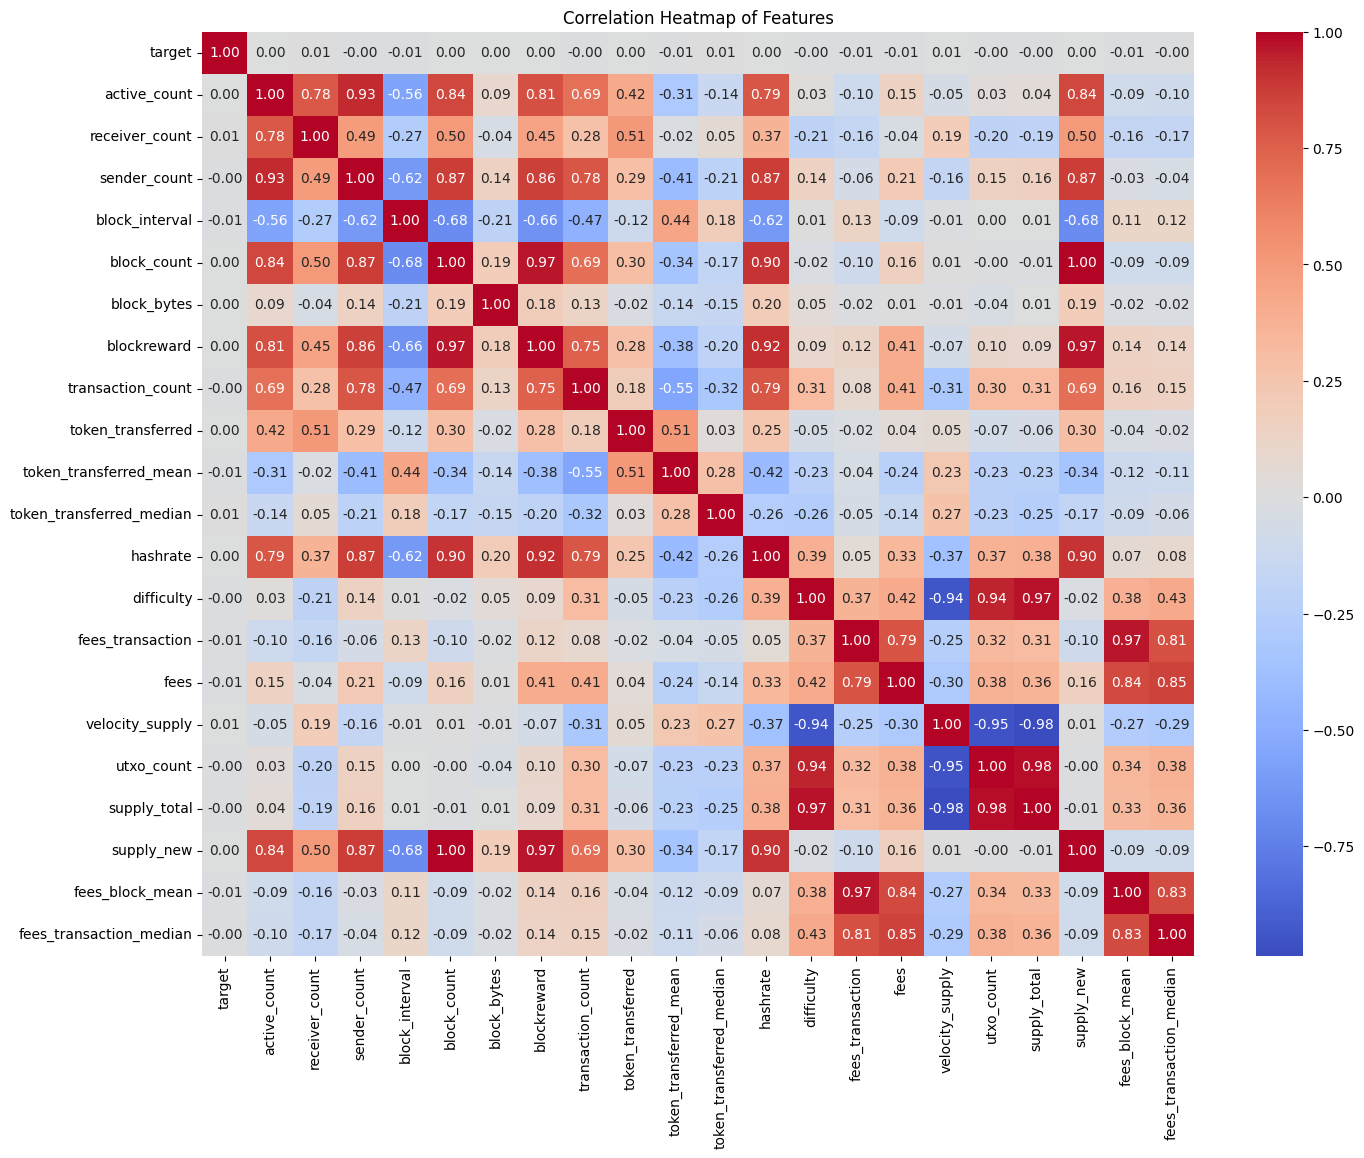

In [20]:
# 상관관계 계산
correlation_matrix = eda_df.drop(columns=['ID', '_type']).corr()

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

## 2-2. 강한 상관관계를 지니는 변수 정리

In [21]:
# 상관계수 중에서 0.7 이상인 경우 찾기 (양의 상관관계)
positive_correlations = correlation_matrix.unstack().sort_values(ascending=False)

# 상관계수 중에서 -0.7 이하인 경우 찾기 (음의 상관관계)
negative_correlations = correlation_matrix.unstack().sort_values()

# 상관계수가 1인 자기 자신을 제외한 상위 쌍들 필터링
positive_correlations = positive_correlations[positive_correlations != 1]
negative_correlations = negative_correlations[negative_correlations != 1]

# 양의 상관관계 (0.7 이상)
positive_threshold = 0.7
strong_positive_pairs = positive_correlations[positive_correlations >= positive_threshold].drop_duplicates()

# 음의 상관관계 (-0.7 이하)
negative_threshold = -0.7
strong_negative_pairs = negative_correlations[negative_correlations <= negative_threshold].drop_duplicates()

In [22]:
# 결과 출력
strong_positive_pairs

supply_total             utxo_count                 0.977959
                         difficulty                 0.974222
supply_new               blockreward                0.965817
blockreward              block_count                0.965817
fees_transaction         fees_block_mean            0.965035
utxo_count               difficulty                 0.938667
sender_count             active_count               0.928941
blockreward              hashrate                   0.920324
supply_new               hashrate                   0.901346
hashrate                 block_count                0.901346
block_count              sender_count               0.874963
supply_new               sender_count               0.874963
hashrate                 sender_count               0.872643
blockreward              sender_count               0.864485
fees_transaction_median  fees                       0.852701
active_count             block_count                0.839558
supply_new               active_count               0.839558
fees_block_mean          fees                       0.835925
                         fees_transaction_median    0.827105
active_count             blockreward                0.813817
fees_transaction         fees_transaction_median    0.810266
fees                     fees_transaction           0.792241
transaction_count        hashrate                   0.788597
active_count             hashrate                   0.788149
sender_count             transaction_count          0.784067
active_count             receiver_count             0.775554
transaction_count        blockreward                0.746606
dtype: float64

In [23]:
strong_negative_pairs

velocity_supply  supply_total   -0.984982
                 utxo_count     -0.951304
                 difficulty     -0.942850
dtype: float64

# 3. 이상치 확인

## 3-1. 변수별 박스플롯
- 전반적으로 우측 꼬리의 분포를 가지고 있기에 우측에 이상치가 많이 분포한 것을 확인할 수 있다.
- 대부분의 변수가 많은 이상치를 보유하고 있었다.
- block_bytes의 경우 좌우로 많은 이상치를 보유한 것을 확인할 수 있었다.

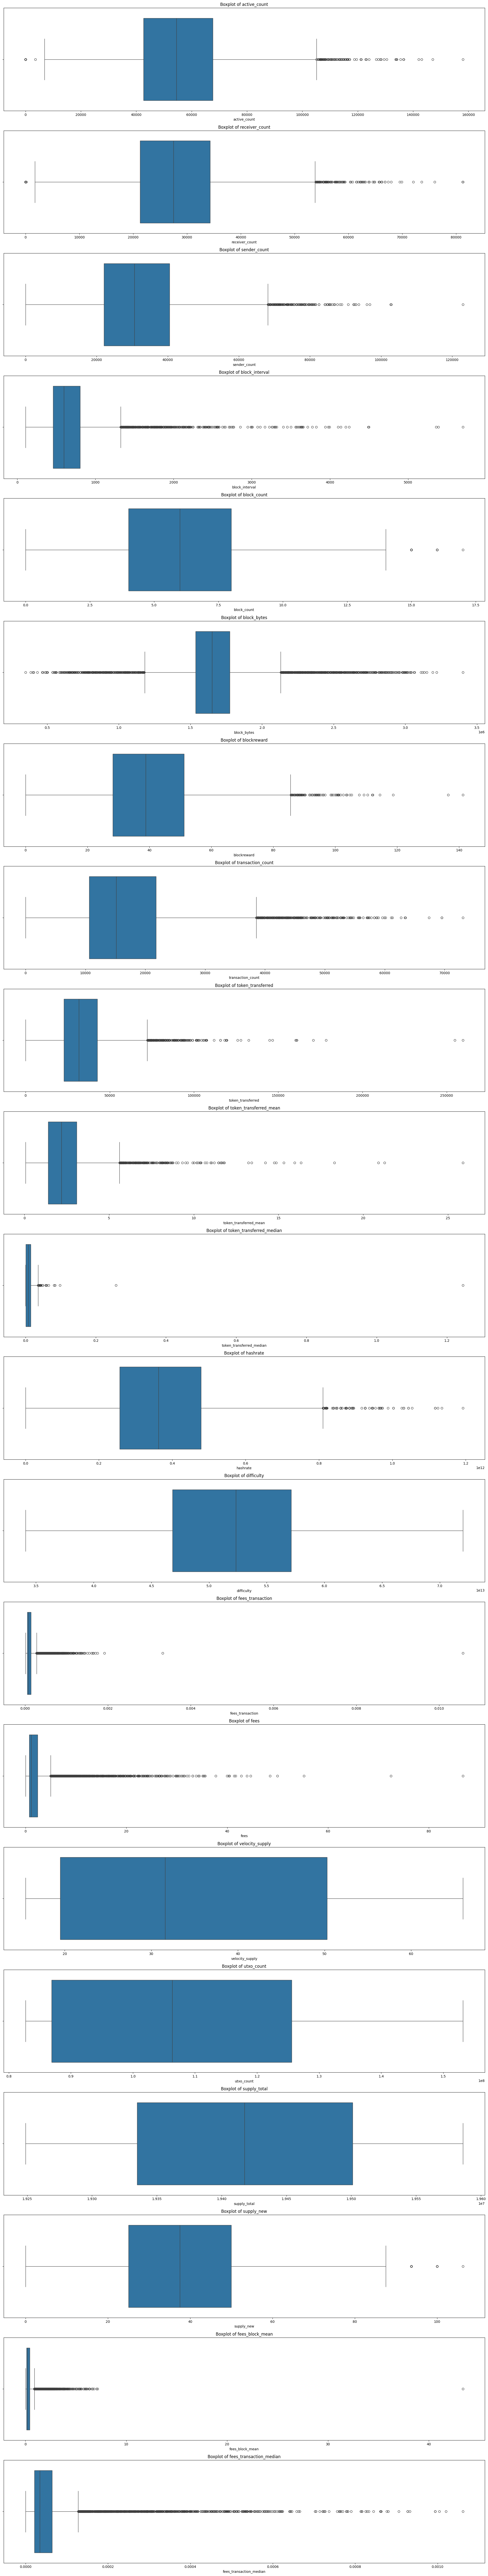

In [24]:
# 변수 리스트 (수치형 변수만 선택)
numeric_columns = eda_df.drop(columns='target').select_dtypes(include=['float64', 'int64']).columns

# 각 변수에 대해 박스플롯 그리기
plt.figure(figsize=(20, len(numeric_columns) * 5))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=eda_df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

## 3-2. 변수별 타겟별 박스풀롯
- 앞서 확인했듯이 평균이나 중위수의 경우 타겟별로 큰 차이를 보이지 않았다.
- 변수별 박스플롯과 비슷하게 우측 꼬리의 형태를 타겟별로도 지니는 것을 확인할 수 있었다.
- block_bytes의 경우 타겟별로도 좌우로 많은 이상치를 보유한 것을 확인할 수 있었다.

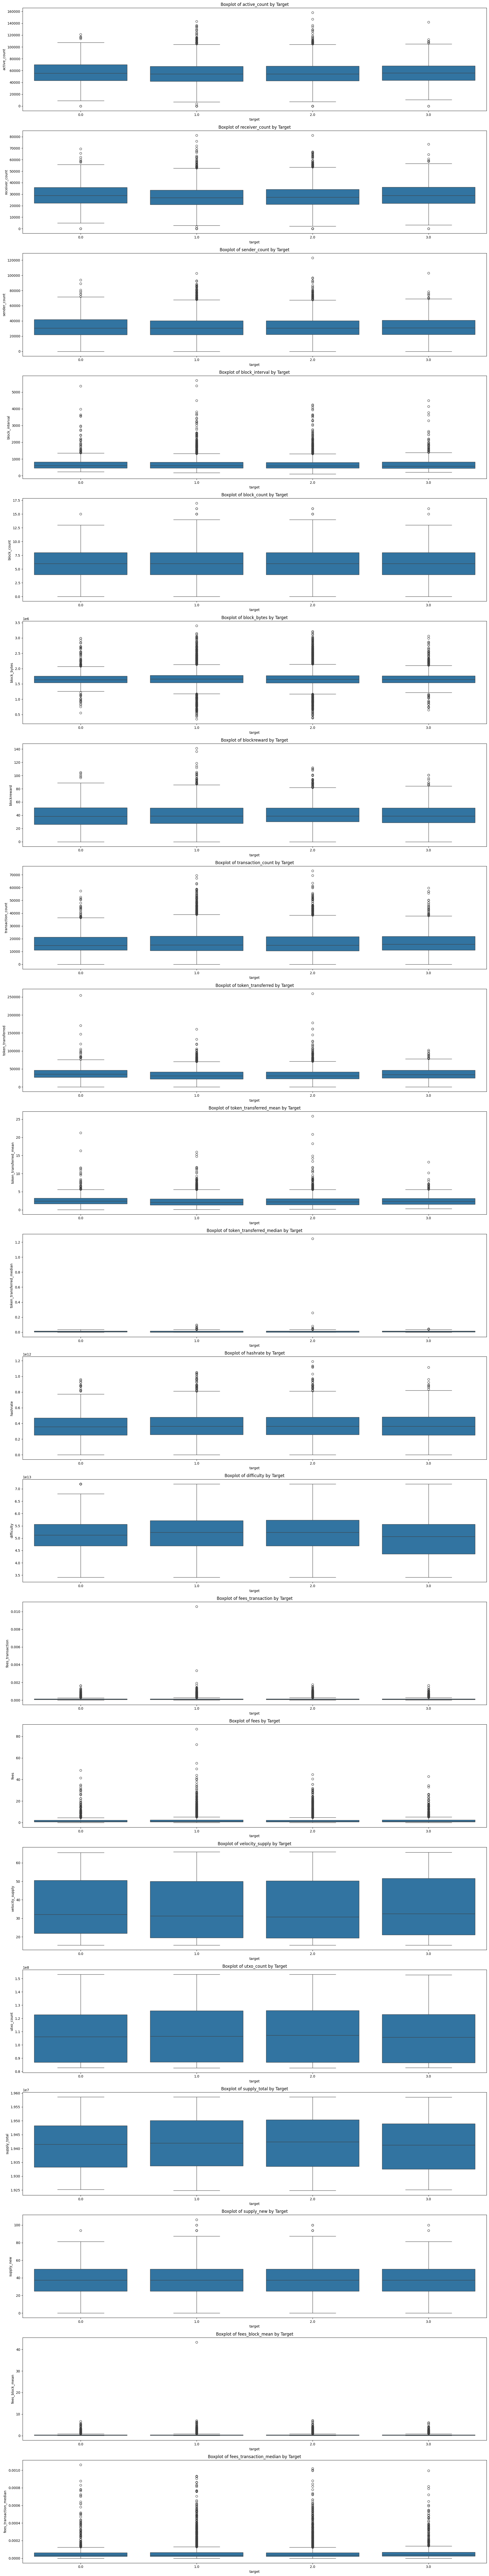

In [25]:
# 각 변수에 대해 타겟별로 박스플롯 그리기
plt.figure(figsize=(20, len(numeric_columns) * 5))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=eda_df['target'], y=eda_df[column])
    plt.title(f'Boxplot of {column} by Target')

plt.tight_layout()
plt.show()

## 3-3. 이상치 정리
- 전반적으로 이상치를 많이 보유하고 있는 경향을 보이기에 이상치를 처리하는 과정에 대해 생각해보아야할 거 같다.
- 특히 우측 꼬리의 형태를 나타내기에 스케일링이나 로그 변환, 윈저화 등을 고려해볼만하다.

# 4. 시계열 분석

## 4-1. 일 단위 분석
- hashrate, difficulty, utxo_count는 증가하는 추세를 보인다.
- receiver_count, velocity_supply는 감소하는 추세를 보인다.
- tokens_transferred_median, fees_transaction, fees, fees_block_mean, fees_transaction_median는 특정시기에 폭등하는 추세를 지닌다.
- active_count, receiver_count, sender_count, block_count, blockreward, hashrate, supply_new는 특정시기에 폭락하는 추세를 지닌다.

In [29]:
# 'ID' 컬럼을 datetime 형식으로 변환
eda_df['ID'] = pd.to_datetime(eda_df['ID'])

# 'ID' 컬럼을 인덱스로 설정 (리샘플링에 필요)
eda_df.set_index('ID', inplace=True)

numeric_columns = eda_df.select_dtypes(include=['float64', 'int64']).columns

# 하루(Daily) 단위 리샘플링
plt.figure(figsize=(20, len(numeric_columns) * 5))

window_size = 31

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)

    # 하루 단위로 데이터 리샘플링 (평균 사용)
    resampled_data = eda_df[column].resample('D').mean()

    # 원래 시계열 데이터 플롯
    plt.plot(resampled_data, label=f'{column} (Daily)', color='blue')

    # 선형 회귀를 위한 데이터 준비
    x = np.arange(len(resampled_data)).reshape(-1, 1)  # 날짜를 숫자로 변환 (1차원 배열)
    y = resampled_data.values.reshape(-1, 1)  # 리샘플된 데이터를 y로 설정

    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(x, y)
    trend_line = model.predict(x)

    # 선형 회귀 추세선 추가
    plt.plot(resampled_data.index, trend_line, label=f'{column} (Linear Trend)', color='red', linestyle='--')

    plt.title(f'Daily Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.